# Acoustic Analyzer
Welcome to Acoustic Analyzer, an open source computational package for performing modal analysis of beams. This package aims to provide a comprehensive and user-friendly tool for analysing the vibrational modes of beams and understanding their acoustic behaviour, and it is designed to meet the needs of researchers, engineers, students, and other professionals in the field of acoustics and structural dynamics.

This documentation is intended to serve as a comprehensive guide to Acoustic Analyzer, providing detailed information on the package's features, functions, and modules, as well as examples of how to use them to solve practical problems. It also explains the underlying theory and concepts behind modal analysis and beam acoustics, so that you can gain a deeper understanding of the results and implications of your analyses.

We believe that Acoustic Analyzer will be a valuable tool for researchers, engineers, and students who seek to analyze and optimize the acoustic behaviour of beams, and we are committed to supporting the package through ongoing development, documentation, and user support. If you have any questions, suggestions, or feedback, please do not hesitate to contact us or contribute to the project on GitHub. We thank you for your interest in Acoustic Analyzer and look forward to your contributions and feedback.

## Example Problems
The section includes example problems that demonstrate how to use Acoustic Analyzer's functions and modules. These examples cover a range of topics and provide step-by-step instructions, sample code, and graphical output to help you understand the problem and its solution. By working through these examples, you can gain a deeper understanding of the package's capabilities and learn how to apply them to your own projects.

### Problem 1: Finding the natural frequency and mode shape of a L shaped beam

We must first import frame from our package. The frame is the object within which we create members and joints. 

In [1]:
from acoustic_analyser import frame

The shape we are trying to make for this example is as follows:
L shape 90 degree, fixed end free end


We can define our shape using two methods.

In [2]:
# Method 1: Directly defining the shape
test_frame = frame()

# Using the height to find the inertia and cross section area
height = 1.27e-2

# Here we define members with the given properties
test_frame.add_member(
    length=0.5,
    density=7800,
    youngs_modulus=206e9,
    height=height,
    cross_section_area=height * height,
    inertia=height**4 / 12,
    id=0,
)
test_frame.add_member(
    length=0.5,
    density=7800,
    youngs_modulus=206e9,
    height=height,
    cross_section_area=height * height,
    inertia=height**4 / 12,
    id=1,
)

# We then link the members using a joint, while specifying the angle between them
joint = test_frame.two_member_joint(member_1_id=0, member_2_id=1, theta=90)

# We then add the constraints for the shape, mainly a fixed and a free end
free_end = test_frame.fixed_end(member_id=0)
free_end = test_frame.free_end(member_id=1)

For understanding the second method we first need to understand how to represent our members and joints as input files. For the same figure above we need to define the members(i.e. define their properties) and also define the connections between the members

#### Member File: JSON

In [3]:
# We can create a python dictionary containing the member ids and their properties
import json

height = 1.27e-2
data = {
    # Here we define a member with id 0 and define its properties
    "0": {
        "youngs_modulus": 206e9,
        "density": 7800,
        "height": height,
        "cross_section_area": height * height,
        "inertia": height**4 / 12,
        "length": 0.5,
    },
    "1": {
        "youngs_modulus": 206e9,
        "density": 7800,
        "height": height,
        "cross_section_area": height * height,
        "inertia": height**4 / 12,
        "length": 0.5,
    },
}
# We can convert the following dictionary to json
json_data = json.dumps(data)

# Then we can save it as a file and use it
f = open("test_member.json", "w")
f.write(json_data)
f.close()

#### Member File: CSV

For this convention we borrow an idea from the adjacency matrix in graph theory. We construct the following table using the rules below:
* If $Member_i$ and $Member_j$ are connected with angle $\theta$ between them, $Row(i,j)=\theta$ $\quad \forall \quad i>j$
* If $Member_i$ and $Member_j$ are not connected, $Row(i,j)=-1$ $\quad \forall \quad i>j$
* $Row(i,j)=-1$ $\quad \forall \quad j \geq i$

For our example we can make the following table

|              | **Member 0** | **Member 1** |
|--------------|--------------|--------------|
| **Member 0** | -1           | 90           |
| **Member 1** | -1           | -1           |

In [4]:
# We can write the table above to a file as follows
csv_data = """-1,90
-1,-1
"""

f = open("test_constraint.csv", "w")
f.write(csv_data)
f.close()

In [5]:
# Method 2: Using input files to define shape

# We can import the same configuration from the files
test_frame = frame.from_file(
    member_file="test_member.json", constraint_file="test_constraint.csv", debug=False
)

# We then add the constraints for the shape, mainly a fixed and a free end
free_end = test_frame.fixed_end(member_id=0)
free_end = test_frame.free_end(member_id=1)

Now we can simply call for the natural frequency, here we get back the $n^{th}$ natural frequency

In [6]:
natural_freq = test_frame.get_natural_frequency(n=1)
print(f"The Natural frequency is {natural_freq}")

Checking region [13, 14]           
Possible root in region [13, 14]
Natural frequency found at 13.742778778076172                                                       
The Natural frequency is [13.742778778076172]


Similarly, we can simply call for the mode shape.

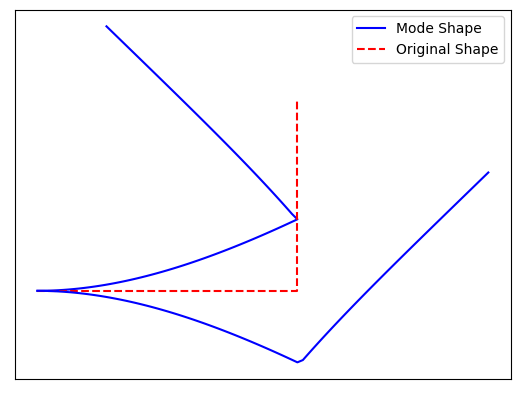

In [7]:
deformation = test_frame.get_mode_shape(natural_freq=natural_freq[0])

The above results were verified against Syam's thesis

### Problem 2: Finding the natural frequency across various angles

We can simply change the angle of the joint by the following code. We can thus generate the plot easily using a simple loop. To increase the speed, we can use the Newton-Raphson algorithm for finding natural frequencies by using the function `get_natural_frequency_newton(initial_guess=guess)`. This function is a lot faster however requires an initial guess to find the frequency.

In [10]:
joint = test_frame.constraints[0]
joint.theta = 0

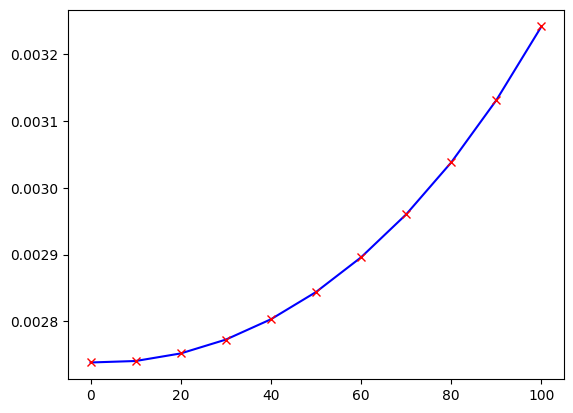

In [11]:
import numpy as np
from matplotlib import pyplot as plt

thetas = np.arange(0, 101, step=10)
natural_freqs = np.zeros(len(thetas))
initial_guess = 10
for i in range(len(thetas)):
    joint.theta = thetas[i] * np.pi / 180
    natural_freq = test_frame.get_natural_frequency_newton(
        initial_guess=initial_guess, print_det=False
    )
    natural_freqs[i] = natural_freq
    initial_guess = natural_freq

non_dimensional_natural_freq = test_frame.members[0].get_non_dimensional_freq(
    w=natural_freqs
)
plt.plot(thetas, non_dimensional_natural_freq, "b")
plt.plot(thetas, non_dimensional_natural_freq, "rx")

The plot above has been validated using the plot from Syam's thesis. 

### Problem 3: Tackling more complicated shapes

We will find the natural frequency and mode shape of the following figure. At present any figure that comprises of two member joints can be worked on using this package.
FIGURE

In [12]:
import json

height = 1.27e-2
data = {
    "0": {
        "youngs_modulus": 206e9,
        "density": 7800,
        "height": height,
        "cross_section_area": height * height,
        "inertia": height**4 / 12,
        "length": 0.5,
    },
    "1": {
        "youngs_modulus": 206e9,
        "density": 7800,
        "height": height,
        "cross_section_area": height * height,
        "inertia": height**4 / 12,
        "length": 0.5,
    },
    "2": {
        "youngs_modulus": 206e9,
        "density": 7800,
        "height": height,
        "cross_section_area": height * height,
        "inertia": height**4 / 12,
        "length": 0.5,
    },
    "3": {
        "youngs_modulus": 206e9,
        "density": 7800,
        "height": height,
        "cross_section_area": height * height,
        "inertia": height**4 / 12,
        "length": 0.5,
    },
}
json_data = json.dumps(data)

f = open("test_member.json", "w")
f.write(json_data)
f.close()

csv_data = """-1,60,-1,-1
-1,-1,300,-1
-1,-1,-1,300
-1,-1,-1,-1
"""

f = open("test_constraint.csv", "w")
f.write(csv_data)
f.close()

test_frame = frame.from_file(
    member_file="test_member.json", constraint_file="test_constraint.csv", debug=False
)

free_end = test_frame.fixed_end(member_id=0)
free_end = test_frame.free_end(member_id=3)

natural_freqs = test_frame.get_natural_frequency(n=2)

Checking region [3, 4]           
Possible root in region [3, 4]
Natural frequency found at 3.298828125                                                              
Checking region [13, 14]           
Possible root in region [13, 14]
Natural frequency found at 13.89697265625                                                           


Below are two figures, one generated using ansys and one using this package. We can see that the mode shapes generated are the same. Thus we can use this to validate our outputs.

The First Mode Shape:

Ansys:

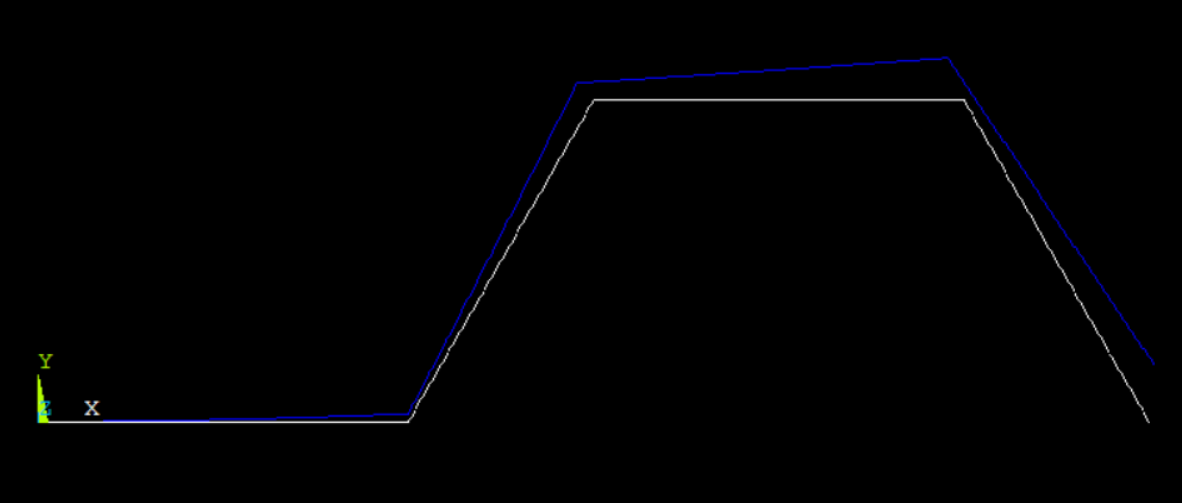

Our Code:


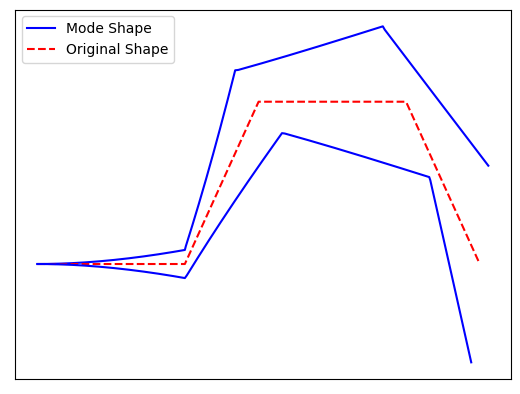

In [13]:
_ = test_frame.get_mode_shape(natural_freq=natural_freqs[0])

**The Second Mode Shape.** 

Ansys:

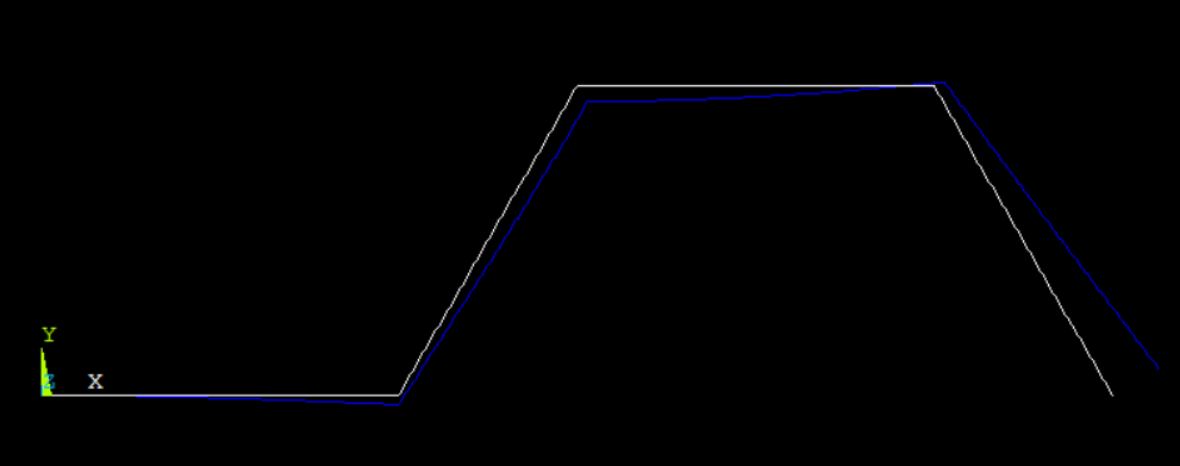 

Our Code:

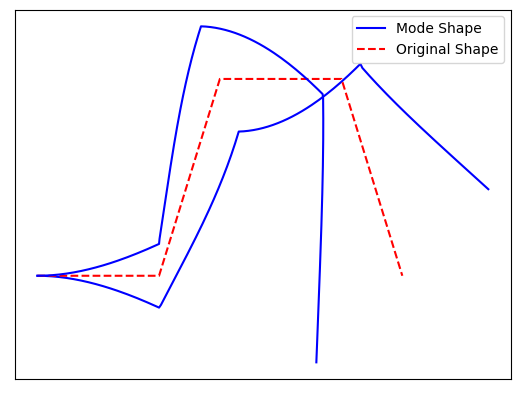

In [14]:
_ = test_frame.get_mode_shape(natural_freq=natural_freqs[1])

## Understanding the code: An overview
This section includes a bird's eye view of the code structure and the modules that it contains. The goal is the give a broad understanding of how all the pieces come together in order to allow developers to take this project forward. The structure has been designed in order to make it as easy as possible to build on the code moving forward.

### Directory Structure:
Here is the structure followed in the code where only the significant files are highlighted. We will be going over these files in this section.
```
├── equations
│   ├── cross_section.pkl
│   ├── fixed_end.pkl
│   └── free_end.pkl
├── generate_equation_file.py
├── main.py
└── modules
    ├── bc.py
    ├── joint.py
    ├── member.py
    ├── rt_bc.py
    └── rt_joint.py
```

### Role of various elements:
#### modules/member.py:
This file contains classes that model the beam members in our structure. These members are the building blocks of the code and are responsible for the mechanical properties and the wave equations which are used in modelling the behaviour of waves in materials. Here currently the members rely on Euler-Bernoulli beam theory which can be changed in future iterations. 

Responsibilities of a member:
* Save the mechanical properties of a member such as youngs modulus, inertia etc.
* Calculate the deflections in the member using the beam theory given the wave parameters
* Store and calculate the relation between the wave parameters at the ends of the member
* Keep track of the internal sign convention and correct for the global sign convention of the structure

#### modules/joint.py:
This file contains classes that model the connections between beam members in our structure. Here is where various types of joints would be implemented in the future, say a 3-member joint or a curved joint. 

Responsibilities of a joint:
* Use the reflection and transmission matrix to create equations between wave parameters between two or more members

#### modules/bc.py:
This file contains classes that model the boundary conditions in our structure. Here is where the fixed and the free end have been implemented.

Responsibilities of a Boundary Condition:
* Use the reflection and transmission matrix to create equations between wave parameters of a member


#### modules/rt_bc.py or rt_joint.py:
This file contains functions that substitute the physical properties of the members and use them to numerically calculate the reflection and transmission matrix for joints and bcs. They load the pkl files in which the pre-computed equations are stored


#### generate_equation_file.py:
This file takes equations from the thesis, and creates sympy objects with the matrices from the equations. It stores the objects as pkl files under equations/ which is then used by rt_bc.py or rt_joint.py to substitute and find the matrices from. 


#### main.py:
This file is where the code comes together in the class frame. The user interacts with this class which creates members and joints as neccessary. 

Responsibilities of a frame:
* Create and store members and joints based on user input
* Collect equations from the modules to create the A matrix
* Solve and compute various mechanical properties such as the mode shape and the natural frequency. 

## Understanding the code: A Deeper dive
The codeflow section of the documentation serves as a critical resource for users seeking to gain a comprehensive understanding of the inner workings of the package. Through this section, we would like to enable users to troubleshoot issues and work on improving the package. We will be going over an example problem and understanding the various functions that play a role in it.